In [10]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.src.legacy.preprocessing.image import ImageDataGenerator
from keras import layers, models
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler

print(f"TensorFlow version: {tf.__version__}")


TensorFlow version: 2.17.0


In [6]:
indian_flag_folder = r'indian_flag_resized',
other_than_indian_flag_folder = r'other_than_indian_flag_resized',
similar_to_india_folder = r'similar_to_india_resized'

datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=20, 
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    shear_range=0.2, 
    zoom_range=0.2, 
    horizontal_flip=True, 
    validation_split=0.2  
)


train_generator = datagen.flow_from_directory(
    'dataset', 
    target_size=(150, 150), 
    batch_size=32, 
    class_mode='categorical', 
    subset='training'  
)

validation_generator = datagen.flow_from_directory(
    'dataset', 
    target_size=(150, 150), 
    batch_size=32, 
    class_mode='categorical', 
    subset='validation' 
)


Found 479 images belonging to 3 classes.
Found 119 images belonging to 3 classes.
Found 119 images belonging to 3 classes.


# Model

In [7]:

model = models.Sequential()


model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))  

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


model.summary()


e:\projects\indian flag detection\flag\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     3,211,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,454,147 (13.18 MB)

 Trainable params: 3,454,147 (13.18 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
def lr_scheduler(epoch, lr):
    if epoch < 5:
        return float(lr)
    else:
        return float(lr * tf.math.exp(-0.1) )


In [16]:
early_stopping = EarlyStopping(
    monitor='val_loss',  
    patience=5,          
    verbose=1,
    restore_best_weights=True  
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  
    factor=0.2,         
    patience=3,          
    min_lr=1e-6,         
    verbose=1
)

checkpoint = ModelCheckpoint(
    'best_model.keras',    
    monitor='val_loss', 
    save_best_only=True,
    verbose=1
)

lr_schedule = LearningRateScheduler(lr_scheduler, verbose=1)

model.compile(
    loss='categorical_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy']
)

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=50,  
    callbacks=[early_stopping, reduce_lr, checkpoint, lr_schedule] 
)



Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.6176 - loss: 0.9530
Epoch 1: val_loss improved from inf to 0.86005, saving model to best_model.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 250ms/step - accuracy: 0.6170 - loss: 0.9509 - val_accuracy: 0.5833 - val_loss: 0.8601 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/50
 1/14 ━━━━━━━━━━━━━━━━━━━━ 2s 171ms/step - accuracy: 0.5938 - loss: 0.9027
Epoch 2: val_loss improved from 0.86005 to 0.62473, saving model to best_model.keras


C:\Users\backu\AppData\Local\Programs\Python\Python311\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5938 - loss: 0.9027 - val_accuracy: 0.7826 - val_loss: 0.6247 - learning_rate: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/50

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.6449 - loss: 0.8116
Epoch 3: val_loss did not improve from 0.62473
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 199ms/step - accuracy: 0.6449 - loss: 0.8105 - val_accuracy: 0.6354 - val_loss: 0.7034 - learning_rate: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/50
 1/14 ━━━━━━━━━━━━━━━━━━━━ 2s 160ms/step - accuracy: 0.6250 - loss: 0.8038
Epoch 4: val_loss did not improve from 0.62473
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6250 - loss: 0.8038 - val_accuracy: 0.6957 - val_loss: 0.7170 - learning_rate: 0.0010

Epoch 5: LearningRateScheduler setting learning rate to 0.0010

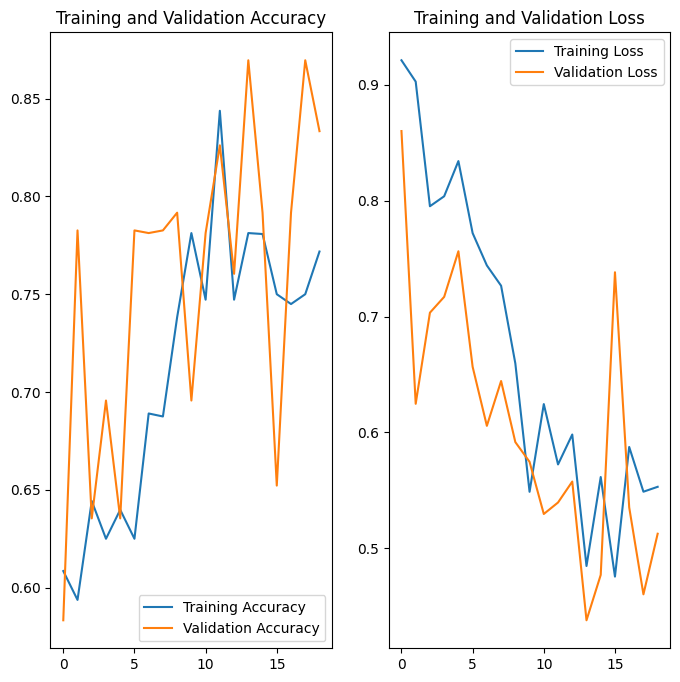

In [17]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [22]:

from tensorflow.keras.models import load_model
model = load_model('1.keras')


from tensorflow.keras.preprocessing import image

def load_image(img_path):
    img = image.load_img(img_path, target_size=(150, 150))
    img_tensor = image.img_to_array(img)
    img_tensor = np.expand_dims(img_tensor, axis=0) 
    img_tensor /= 255. 
    return img_tensor

img_path = 'similar_to_india/3d-waving-flag-cote-d-ivoire-isolated-on-white-vector-34091281.jpg'
new_image = load_image(img_path)
pred = model.predict(new_image)
categories = ['Indian Flag', 'Other', 'Similar to Indian Flag']
predicted_class = categories[np.argmax(pred)]
print(f"Predicted class: {predicted_class}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
Predicted class: Similar to Indian Flag
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
Predicted class: Similar to Indian Flag
